<a href="https://colab.research.google.com/github/MarciaFG/scimobility/blob/main/LaplacianMatrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 800*800 Laplacian Matrix from Meso-Fields

* Calculate the Laplacian matrix of the square matrix.
* Calculate the eigenvalues and eigenvectors of the Laplacian matrix.
* Sort the eigenvalues in ascending order.
* The second smallest eigenvalue corresponds to the second eigenvector.
* Normalize the second eigenvector to have a unit length.

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, 
and then re-execute this cell.
Your runtime has 13.6 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime → "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


In [2]:
import numpy as np
import requests
import pandas as pd
from tqdm import tqdm
import torch
import nltk
import io
import matplotlib.pyplot as plt
from google.cloud import bigquery
from google.colab import files
import humanize
!pip install 'networkx<2.7'
!pip install 'scipy>=1.8'
#!pip install google-sheets-to-csv
# enable data table format
from google.colab import data_table
data_table.enable_dataframe_formatter()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os.path
from google.colab import drive

# mount Google Drive to /content/drive/My Drive/
if os.path.isdir("/content/drive/My Drive"):
  print("Google Drive already mounted")
else:
  drive.mount('/content/drive/')

Google Drive already mounted


In [4]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
id = '17RXABV5bp0-u_oSvKmKONW3f7FLzrjYl'
print (id) # Verify that you have everything
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('MesoFieldsMatrix.csv')  
edgelist = pd.read_csv('MesoFieldsMatrix.csv', sep=";") # Dataset is now stored in a Pandas Dataframe
edgelist.head(1)
print(edgelist.dtypes)

17RXABV5bp0-u_oSvKmKONW3f7FLzrjYl
source    int64
target    int64
weight    int64
dtype: object


In [5]:
# concatenate the source and target columns to create a node list
nodelist = pd.concat([edgelist['source'], edgelist['target']]).unique()

# print the node list
print("Node list: ", nodelist[0:10])

Node list:  [0 1 2 3 4 5 6 7 8 9]


In [6]:
from networkx.linalg.graphmatrix import adjacency_matrix
import pandas as pd
import numpy as np
import networkx as nx

G=nx.from_pandas_edgelist(edgelist,'source','target','weight')

In [7]:
Degrees = nx.degree(G, weight='weight')
print(Degrees[0])

944790


In [8]:
# Compute the Laplacian matrix
# The graph Laplacian is the matrix L = D - A, where A is the adjacency matrix and D is the diagonal matrix of node degrees.
laplacian_matrix = nx.laplacian_matrix(G, nodelist = nodelist, weight='weight').astype(float)

# print the shape of the Laplacian matrix
print("Laplacian matrix shape: ", laplacian_matrix.shape)

# Convert the Laplacian matrix to a dense numpy array and inspect
laplacian_matrix_array = laplacian_matrix.toarray()
df = pd.DataFrame(laplacian_matrix_array, columns=G.nodes(), index=G.nodes())
print(df.head(5))

Laplacian matrix shape:  (865, 865)
        0          1         2         3          4       5       6    \
0  944790.0    -3990.0      -2.0     -75.0       -6.0   -28.0   -14.0   
1   -3990.0  1517891.0     -19.0     -86.0     -104.0   -79.0 -4067.0   
2      -2.0      -19.0  363783.0   -5065.0     -225.0  -325.0  -807.0   
3     -75.0      -86.0   -5065.0  539938.0     -526.0  -352.0  -782.0   
4      -6.0     -104.0    -225.0    -526.0  2062685.0 -2063.0  -354.0   

       7        8      9    ...    841   846  857     840   810    811   842  \
0     -3.0    -87.0 -127.0  ...   -4.0  -4.0  0.0     0.0   0.0   -1.0  -2.0   
1   -856.0  -3839.0  -44.0  ... -114.0 -51.0 -4.0   -79.0  -4.0    0.0 -12.0   
2  -2164.0    -95.0  -23.0  ...  -60.0  -3.0 -1.0 -1469.0 -25.0  -16.0  -1.0   
3  -5164.0   -300.0 -251.0  ...  -23.0  -3.0 -3.0   -32.0 -60.0 -116.0  -5.0   
4 -13158.0 -15833.0  -61.0  ...  -18.0  -4.0 -8.0   -88.0 -30.0    0.0 -16.0   

   843    830     844  
0  0.0   -7.0  -526.

In [ ]:
ones = np.ones(865)
#print(ones)

laplacian_matrix * ones

In [10]:
import scipy.sparse.linalg

# compute all the eigenvalues and eigenvectors of the Laplacian matrix
eigenvalues, eigenvectors = scipy.linalg.eigh(laplacian_matrix.toarray())

# print the Laplacian eigenvalues
print("Laplacian eigenvalues: ", eigenvalues)
print("Laplacian eigenvectors: ", eigenvectors)

Laplacian eigenvalues:  [-4.64757642e-11  6.76135336e+02  9.99638239e+02  1.46845268e+03
  1.62084878e+03  1.64603282e+03  1.65277951e+03  1.67762752e+03
  1.70500192e+03  1.74146955e+03  1.75207132e+03  1.75875914e+03
  1.80884930e+03  1.84125343e+03  1.87625750e+03  1.91811793e+03
  1.96984208e+03  2.02769079e+03  2.03190796e+03  2.06154650e+03
  2.13555173e+03  2.16351386e+03  2.34642678e+03  2.35011424e+03
  2.35587733e+03  2.43070148e+03  2.44849990e+03  2.52330681e+03
  2.71351450e+03  2.72814308e+03  2.74364482e+03  2.75426974e+03
  2.81736341e+03  2.84649325e+03  2.90712153e+03  2.91690528e+03
  3.38749441e+03  3.40518370e+03  3.43115479e+03  3.52857381e+03
  3.53189696e+03  3.53395723e+03  3.54523743e+03  3.59440768e+03
  3.59811217e+03  3.60825510e+03  3.66113882e+03  3.69793606e+03
  3.77785212e+03  3.83176385e+03  3.87984455e+03  3.92634227e+03
  3.97923084e+03  3.98932159e+03  4.02191508e+03  4.05281155e+03
  4.13406744e+03  4.18616948e+03  4.20616420e+03  4.29915284e+03
 

In [11]:
print(eigenvalues.shape)
print(eigenvectors.shape)

(865,)
(865, 865)


Text(0, 0.5, 'third_eigenvector')

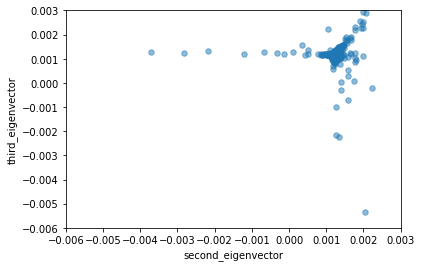

In [12]:
v1 = eigenvectors[:, 0]
v2 = eigenvectors[:, 1]
v3 = eigenvectors[:, 2]

# make a scatterplot of the second and the third eigenvectors
# Set custom axis ranges
plt.xlim(-0.006, 0.003)
plt.ylim(-0.006, 0.003)

plt.scatter(v2, v3, s=30, alpha = 0.5)
plt.xlabel('second_eigenvector')
plt.ylabel('third_eigenvector')

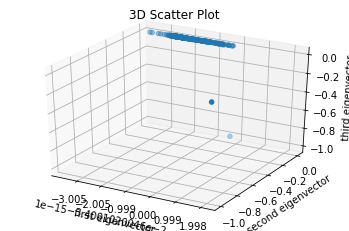

In [13]:
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(v1, v2, v3)

# Add labels and title
ax.set_xlabel('first eigenvector')
ax.set_ylabel('second eigenvector')
ax.set_zlabel('third eigenvector')
ax.set_title('3D Scatter Plot')

# Display the plot
plt.show()

In [14]:
laplacian_matrix * v2
el = 7.82882617e-01 /v2[0]
print(el)

676.1353364708476


3. Sort eigenvalues and eigenvectors: Once you have the eigenvalues and eigenvectors of the Laplacian matrix, you can sort them in ascending order of eigenvalues to identify the most important eigenvectors. Here's an example:

In [ ]:
idx = eigenvalues.argsort()
eigenValues = eigenvalues[idx]
eigenVectors = eigenvectors[:,idx]

# print the sorted eigenvalues and eigenvectors
print("Sorted eigenvalues: ", eigenValues)
print("Sorted eigenvectors: ", eigenVectors)

In [ ]:
import matplotlib.colors

# Create heatmap of Laplacian matrix
fig, ax = plt.subplots()
im = ax.imshow(eigenVectors @ np.diag(eigenValues) @ eigenVectors.T, cmap='YlOrRd')

# Add color bar
cbar = ax.figure.colorbar(im, ax=ax)

# Set axis labels
ax.set_xticks(np.arange(laplacian_matrix.shape[1]))
ax.set_yticks(np.arange(laplacian_matrix.shape[0]))
ax.set_xticklabels([f'Column {i+1}' for i in range(laplacian_matrix.shape[1])])
ax.set_yticklabels([f'Row {i+1}' for i in range(laplacian_matrix.shape[0])])
ax.set_xlabel('Column')
ax.set_ylabel('Row')

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations
for i in range(laplacian_matrix.shape[0]):
    for j in range(laplacian_matrix.shape[1]):
        text = ax.text(j, i, f'{eigenVectors[i, j]:.2f}',
                       ha="center", va="center", color="black")

# Set title
ax.set_title("Laplacian Heatmap")

plt.show()

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Create list of tuples
eig_pairs = list(zip(eigenvalues, eigenvectors))

# Sort list of tuples based on eigenvalues
sorted_eig_pairs = sorted(eig_pairs, key=lambda x: x[0])

# Extract sorted eigenvalues and eigenvectors
sorted_eigenvalues = [pair[0] for pair in sorted_eig_pairs]
sorted_eigenvectors = [pair[1] for pair in sorted_eig_pairs]

# Create sorted matrix
sorted_A = np.dot(np.dot(sorted_eigenvectors, np.diag(sorted_eigenvalues)), np.linalg.inv(sorted_eigenvectors))

# Create heatmap of sorted matrix
fig, ax = plt.subplots()
im = ax.imshow(sorted_A, cmap='YlOrRd')

# Add color bar
cbar = ax.figure.colorbar(im, ax=ax)

# Set axis labels
ax.set_xticks(np.arange(sorted_A.shape[1]))
ax.set_yticks(np.arange(sorted_A.shape[0]))
ax.set_xticklabels(np.arange(sorted_A.shape[1])+1)
ax.set_yticklabels(np.arange(sorted_A.shape[0])+1)
ax.set_xlabel('Column')
ax.set_ylabel('Row')

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations
for i in range(sorted_A.shape[0]):
    for j in range(sorted_A.shape[1]):
        text = ax.text(j, i, f'{sorted_A[i, j]:.2f}',
                       ha="center", va="center", color="black")

# Set title
ax.set_title("Sorted Matrix")

plt.show()



KeyboardInterrupt: ignored

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fec54783280> (for post_execute):


KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7fec72232e50> (for post_execute):


KeyboardInterrupt: ignored

In [88]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors

# Create list of tuples
eig_pairs = list(zip(eigenvalues, eigenvectors))

# Sort list of tuples based on eigenvalues
sorted_eig_pairs = sorted(eig_pairs, key=lambda x: x[0])

# Extract sorted eigenvalues and eigenvectors
sorted_eigenvalues = [pair[0] for pair in sorted_eig_pairs]
sorted_eigenvectors = [pair[1] for pair in sorted_eig_pairs]

# Create sorted Laplacian matrix
sorted_A = np.dot(np.dot(sorted_eigenvectors, np.diag(sorted_eigenvalues)), np.linalg.inv(sorted_eigenvectors))

# Get sorted indices
sorted_indices = [pair[1] for pair in sorted_eig_pairs]

# Get original vertex indices
original_indices = list(range(L.shape[0]))

# Create dictionary to map sorted indices to original indices
index_dict = {sorted_indices[i]: original_indices[i] for i in range(len(sorted_indices))}

# Create heatmap of sorted Laplacian matrix with original vertex indices
fig, ax = plt.subplots()
im = ax.imshow(sorted_L, cmap='YlOrRd', norm=matplotlib.colors.LogNorm())

# Add color bar
cbar = ax.figure.colorbar(im, ax=ax)

# Set axis labels
ax.set_xticks(np.arange(sorted_L.shape[1]))
ax.set_yticks(np.arange(sorted_L.shape[0]))
ax.set_xticklabels([f'Vertex {index_dict[i]+1}' for i in range(sorted_L.shape[1])])
ax.set_yticklabels([f'Vertex {index_dict[i]+1}' for i in range(sorted_L.shape[0])])
ax.set_xlabel('Vertex')
ax.set_ylabel('Vertex')

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations
for i in range(sorted_L.shape[0]):
    for j in range(sorted_L.shape[1]):
        text = ax.text(j, i, f'{sorted_L[i, j]:.2f}',
                       ha="center", va="center", color="black")

# Set title
ax.set_title("Sorted Laplacian Matrix with Original Vertex Indices")

plt.show()


LinAlgError: ignored

In [ ]:
"""
# count the number of nonzero eigenvalues
num_nonzero_eigenvalues = np.count_nonzero(sorted_eigenvalues)

# count the number of zero eigenvalues
num_zero_eigenvalues = len(sorted_eigenvalues) - num_nonzero_eigenvalues

# print the number of zero eigenvalues
print("Number of zero eigenvalues: ", num_zero_eigenvalues)
print("Number of nonzero eigenvalues: ", num_nonzero_eigenvalues)
"""

Number of zero eigenvalues:  0
Number of nonzero eigenvalues:  3


In [ ]:
"""
num_nonzero_eigenvalues = np.count_nonzero(sorted_eigenvalues)

# count the number of zero eigenvalues
num_zero_eigenvalues = len(sorted_eigenvalues) - num_nonzero_eigenvalues

# print the number of zero eigenvalues
print("Number of zero eigenvalues: ", num_zero_eigenvalues)
"""

Number of zero eigenvalues:  0
